# Land Use and Land Cover Classification task

For this task, I used the whole EuroSAT dataset: 10 image classes with 2000-3000 images per class.

I used two models: ResNet50 -- the one that showed the best results in the paper where the EuroSAT dataset was introduced (https://www.researchgate.net/publication/319463676_EuroSAT_A_Novel_Dataset_and_Deep_Learning_Benchmark_for_Land_Use_and_Land_Cover_Classification)

This model was pretrained on the ImageNet-1k dataset. 
The f1 and AUPRC scores achieved on test data are 0.9882583022117615 and 0.9987589120864868, respectively. I chose these metrics because their performance is representative of imbalanced data. 
I split the data in a 60/20/20 training-validation-test split, and even though the model was trained on fewer data, the results were pretty good.
An important role played learning rate, with lr=10e-5 ResNet50 achieved almost 0.98 f1 score at first epochs, while with lover learning rates (10e-3, 10e-4), the f1 score hardly reached 0.52.

The authors of the dataset used an accuracy metric for model comparison, and it’s 98.57% on an 80/20 training-test spit.

Another model that I used for this task is Vision Transformer. It was pretrained ImageNet-21k and has achieved state-of-the-art performance on a number of image classification benchmarks and has shown great potential for generalizing to new domains.

It showed an even better performance. The f1 and AUPRC scores achieved on test data are 0.9913133382797241 and 0.9989550709724426, respectively. The situation with the learning rate was quite similar to ResNet50: lr=10e-5 showed significantly better results than smaller ones and a bit better than lr=10e-6.

Training script is in .py files:

'train.py' - training

'evaluate.py' - evaluation

'main.py' - data preprocessing and script for training & evaluation

'eurosat.py' and transformereurosat.py - custom Dataset classes.

There is also an Inference script in the notebook, combined with explainability visualizations (using Grad-CAM https://arxiv.org/pdf/1610.02391.pdf) - ‘visual explanations’ for decisions from models. 

P.S. I like how differen the visualisations look for the models


In [1]:
import os
import random

import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from transformers import ViTForImageClassification
from transformers.modeling_outputs import ImageClassifierOutput
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

np.random.seed(42)

INPUT_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Download data

In [3]:
FOLDER_PATH = './2750'

dataset = ImageFolder(FOLDER_PATH)

Loading data

In [4]:
print(f'Classes: {dataset.classes}')
print(f'Number of classes: {len(dataset.classes)}')

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of classes: 10


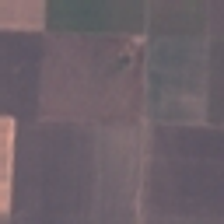

In [5]:
dataset[0][0].resize((INPUT_SIZE,INPUT_SIZE))

In [6]:
from sklearn.utils import shuffle

shuffled_data = shuffle(dataset)

In [ ]:
n = 4
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
    for j in range(n):
        image = shuffled_data[i * n + j][0]
    
        title_index = shuffled_data[i * n + j][1]
        title = dataset.classes[title_index]
        axes[i, j].imshow(image)
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

## Exploratory Data Analysis

Image disribution between classes

<Figure size 800x800 with 0 Axes>

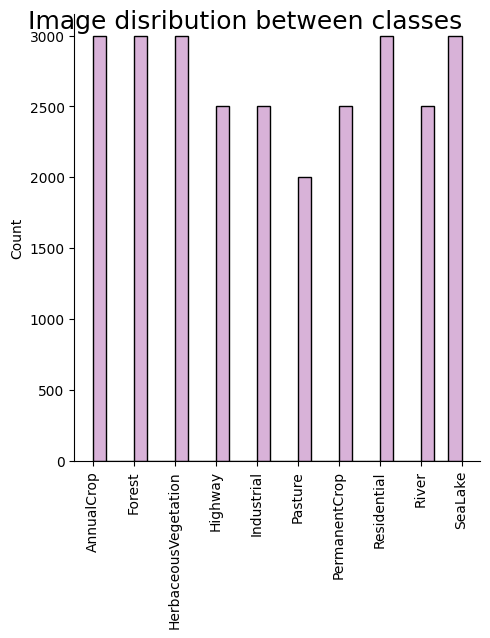

In [8]:
sns.color_palette("rocket")
plt.figure(figsize=(8, 8))
plot = sns.displot(dataset.targets,color="purple", alpha = 0.3)
plot.set(xticks=range(len(dataset.classes)))
plot.set_xticklabels(dataset.classes, rotation=90)
plot.fig.suptitle("Image disribution between classes",
                  fontsize=18, fontdict={"weight": "bold"})

plt.show()

### Load saved models

In [9]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 10)
resnet50_file = 'checkpoints/resnet50-model.pt'
resnet50.load_state_dict(torch.load(resnet50_file))
resnet50.eval()
resnet50.to(device)

/h/kateryna/miniconda3/envs/ttc/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/h/kateryna/miniconda3/envs/ttc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
VIT_CHECKPOINT_PATH = 'google/vit-base-patch16-224-in21k'
vit_file = 'checkpoints/vit-model.pt'
vit = ViTForImageClassification.from_pretrained(VIT_CHECKPOINT_PATH, num_labels=10)
vit.load_state_dict(torch.load(vit_file))
vit.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

## Test performance

In [11]:
from main import prepare_data
from evaluate import evaluate

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
_, _, resnet_test_data = prepare_data('resnet50')
_, _, vit_test_data = prepare_data('vit')

/h/kateryna/miniconda3/envs/ttc/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
resnet50_test_loader = DataLoader(resnet_test_data, batch_size=16, num_workers=2, shuffle=True)
test_loss, test_f1, test_auprc = evaluate(resnet50, device, resnet50_test_loader, len(dataset.classes), criterion)

In [15]:
print(f'Test loss: {test_loss} \n Test f1: {test_f1} \n Test AUPRC: {test_auprc}')

Test loss: 0.04215812463313341 
 Test f1: 0.9882583022117615 
 Test AUPRC: 0.9987589120864868


In [16]:
vit_test_loader = DataLoader(vit_test_data, batch_size=16, num_workers=2, shuffle=True)
vit_test_loss, vit_test_f1, vit_test_auprc = evaluate(vit, device, vit_test_loader, len(dataset.classes), criterion)

In [17]:
print(f'Test loss: {vit_test_loss} \n Test f1: {vit_test_f1} \n Test AUPRC: {vit_test_auprc}')

Test loss: 0.03165724754333496 
 Test f1: 0.9913133382797241 
 Test AUPRC: 0.9989550709724426


## Visualization & explainability + Inference script

In [18]:
def visualization_and_explainability(model, test_data, n, grad_cam):
    
    grad_cam_targets = None
    transform = transforms.ToTensor()
    
    fig, axes = plt.subplots(n, 2, figsize=(10,20))

    for i in range(n):
        original_image, label = test_data[i]

        unsqueezed_image = original_image.unsqueeze(0).to(device)

        output = model(unsqueezed_image)
        
        if isinstance(output, ImageClassifierOutput):
            output = output.logits
            
        _, pred = torch.max(output, 1)


        label = dataset.classes[label]
        pred = dataset.classes[pred[0]]

        image = original_image.cpu().numpy().transpose((1, 2, 0))
        image = np.clip(np.array(IMAGENET_STD) * image + np.array(IMAGENET_MEAN), 0, 1)

        title = f'Pred: {pred}\n GT: {label}'

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(title)
        axes[i, 0].axis('off')

        #gradCAM
        grayscale_cam = grad_cam(input_tensor=unsqueezed_image, targets=grad_cam_targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.float32(image)/255, grayscale_cam, use_rgb=True)

        axes[i, 1].imshow(visualization)
        axes[i, 0].axis('off')

### ResNet50

In [19]:
resnet50_target_layers = [resnet50.layer4[-1]]

resnet50_grad_cam = GradCAMPlusPlus(model=resnet50, target_layers=resnet50_target_layers, use_cuda=True)

In [20]:
visualization_and_explainability(resnet50, resnet_test_data, 6, resnet50_grad_cam)

### ViT

In [21]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [22]:
class ViTWrapper(torch.nn.Module):
    """ViT Wrapper to use with Grad-CAM."""

    def __init__(self, vit: ViTForImageClassification):
        super().__init__()
        self.vit = vit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.vit(x).logits

    @property
    def target_layer(self):
        return self.vit.vit.encoder.layer[-2].layernorm_after

In [23]:
vitwrapper = ViTWrapper(vit)

vit_grad_cam = GradCAMPlusPlus(model=vitwrapper, target_layers=[vitwrapper.target_layer], reshape_transform=reshape_transform, use_cuda=True)

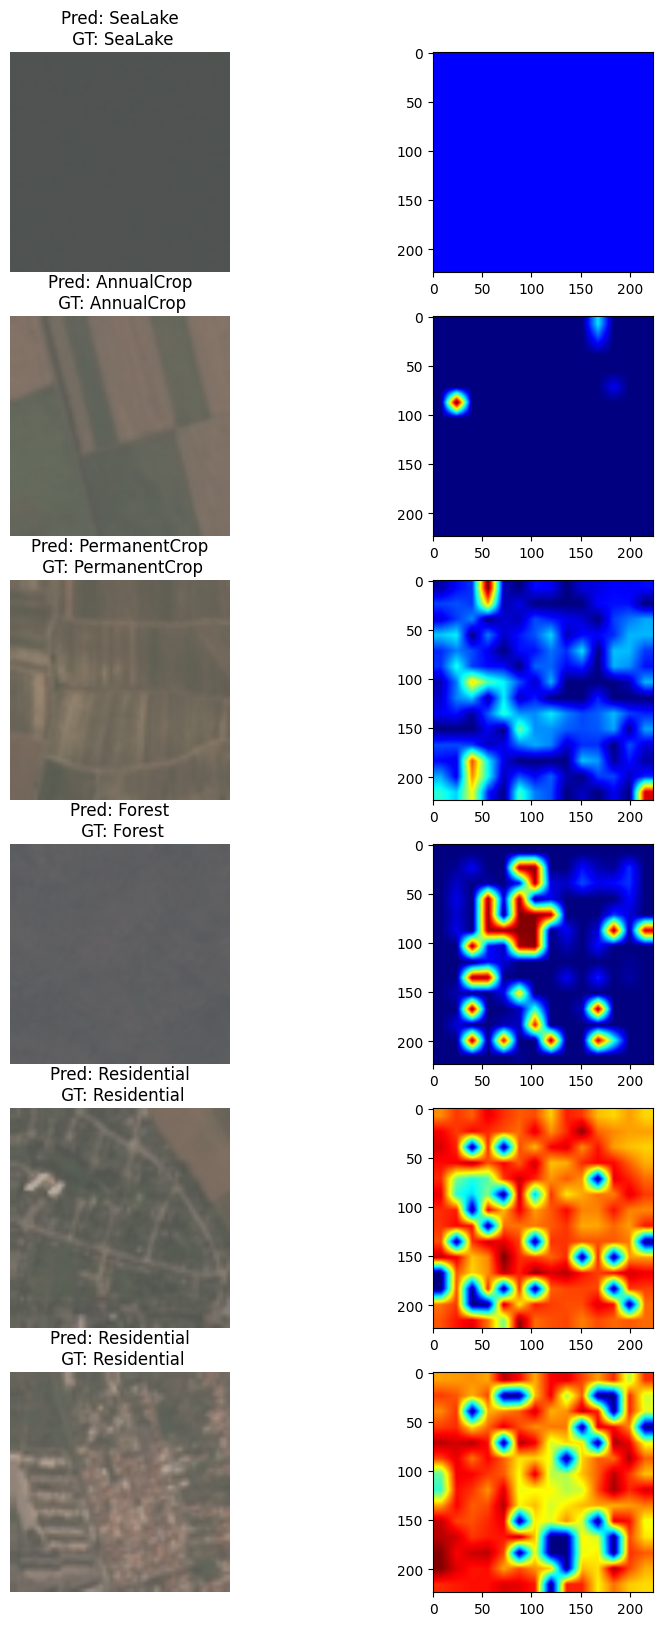

In [24]:
visualization_and_explainability(vit, vit_test_data, 6, vit_grad_cam)